In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import osmnx as ox 
from shapely.geometry import Point, LineString

Read bus stop location data

In [15]:
# 1. read bus stops geojson
bus_stops = gpd.read_file('data/raw/tfl/Bus_Stops.geojson')
bus_stops = bus_stops.to_crs(epsg=27700)
bus_stops['STOP_CODE'] = bus_stops['STOP_CODE'].astype(str).str.strip() # CONVERT STOP_CODE TO STR

# 2. load bus stop data
bus_stops1 = pd.read_csv('data/raw/tfl/bus-stops.csv')
bus_stops1['Bus_Stop_Code'] = bus_stops1['Bus_Stop_Code'].astype(str).str.strip() # CONVERT STOP_CODE TO STR

# combine bus_stops and bus_stops1 with stop_code
bus_stops = bus_stops.merge(bus_stops1, left_on='STOP_CODE', right_on='Stop_Code_LBSL', how='outer')

# fill stop_code with Stop_Code_LBSL
bus_stops['STOP_CODE'] = bus_stops['STOP_CODE'].fillna(bus_stops['Stop_Code_LBSL'])
bus_stops['STOP_NAME'] = bus_stops['STOP_NAME'].fillna(bus_stops['Stop_Name'])
bus_stops['OS_EASTING'] = bus_stops['OS_EASTING'].fillna(bus_stops['Location_Easting'])
bus_stops['OS_NORTHING'] = bus_stops['OS_NORTHING'].fillna(bus_stops['Location_Northing'])
bus_stops['geometry'] = [Point(x, y) for x, y in zip(bus_stops['OS_EASTING'], bus_stops['OS_NORTHING'])]

# filter to necessary columns
bus_stops = bus_stops[['STOP_CODE', 'STOP_NAME', 'OS_EASTING', 'OS_NORTHING','geometry']]
bus_stops = gpd.GeoDataFrame(bus_stops, geometry='geometry', crs='epsg:27700')
bus_stops.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21540 entries, 0 to 21539
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   STOP_CODE    21540 non-null  object  
 1   STOP_NAME    21517 non-null  object  
 2   OS_EASTING   21540 non-null  float64 
 3   OS_NORTHING  21540 non-null  float64 
 4   geometry     21540 non-null  geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 841.5+ KB


Read BUSTO data

In [11]:
# import all csv file in folder
path = os.path.join('data', 'raw', 'tfl', 'busto')
all_files = os.listdir(path)
all_files = [f for f in all_files if f.endswith('.csv')]
all_files = [os.path.join(path, f) for f in all_files]

# read all csv files
dfs = []
for f in all_files:
    df = pd.read_csv(f)
    dfs.append(df)
df = pd.concat(dfs) # concat all dataframes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3293688 entries, 0 to 775288
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   YEAR          int64  
 1   DAY_TYPE      object 
 2   TIMEBAND      int64  
 3   QHr           object 
 4   ROUTE         object 
 5   DIRECTION     int64  
 6   STOPCODE      object 
 7   STOPNAME      object 
 8   STOPSEQUENCE  float64
 9   Boardings     float64
 10  Alightings    float64
 11  Load          float64
 12  Capacity      float64
 13  Seats         float64
 14  V/C           float64
dtypes: float64(7), int64(3), object(5)
memory usage: 402.1+ MB


### AGGREGATE BY STOP AND ROUTE

In [22]:
bus_entex = df.copy()

# aggregate by STOPCODE,STOPNAME,TIMEBAND, sum Alightings
bus_entex = bus_entex.groupby(['STOPCODE', 'STOPNAME','ROUTE', 'TIMEBAND']).agg({'Alightings': 'sum'}).reset_index()

# get geometry for bus_entex from bus_stops
bus_entex= bus_entex.merge(bus_stops[['STOP_CODE', 'geometry']], left_on='STOPCODE', right_on='STOP_CODE', how='left')
bus_entex = bus_entex.drop(columns=['STOP_CODE'])
bus_entex = gpd.GeoDataFrame(bus_entex, geometry='geometry',crs='epsg:27700')
bus_entex.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 219545 entries, 0 to 219544
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   STOPCODE    219545 non-null  object  
 1   STOPNAME    219545 non-null  object  
 2   ROUTE       219545 non-null  object  
 3   TIMEBAND    219545 non-null  int64   
 4   Alightings  219545 non-null  float64 
 5   geometry    219492 non-null  geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 10.1+ MB


SPLIT BY TIME BAND

In [52]:
# pivot by time bands
bus_entex_pivot = bus_entex.pivot_table(index=['STOPCODE','STOPNAME','ROUTE','geometry'], columns='TIMEBAND', values=['Alightings'], aggfunc='sum')
bus_entex_pivot.columns = bus_entex_pivot.columns.droplevel()
bus_entex_pivot = bus_entex_pivot.reset_index().rename_axis(None, axis=1)
bus_entex_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50213 entries, 0 to 50212
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STOPCODE  50213 non-null  object  
 1   STOPNAME  50213 non-null  object  
 2   ROUTE     50213 non-null  object  
 3   geometry  50213 non-null  geometry
 4   8         48302 non-null  float64 
 5   9         42077 non-null  float64 
 6   10        41752 non-null  float64 
 7   11        41001 non-null  float64 
 8   12        46360 non-null  float64 
dtypes: float64(5), geometry(1), object(3)
memory usage: 3.4+ MB


In [53]:
# Create column 1011, sum of 10 and 11
bus_entex_pivot[1011] = bus_entex_pivot[10] + bus_entex_pivot[11]
bus_entex_pivot = bus_entex_pivot.drop(columns=[10, 11])

# rename columns based on timeband
timeband_dict = {
    8: 'Morning',
    9: 'Midday',
    1011: 'Evening',
    12: 'Late'
}
bus_entex_pivot = bus_entex_pivot.rename(columns=timeband_dict)

# add total column
bus_entex_pivot['Total'] = bus_entex_pivot[bus_entex_pivot.columns[4:]].sum(axis=1)
bus_entex_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50213 entries, 0 to 50212
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STOPCODE  50213 non-null  object  
 1   STOPNAME  50213 non-null  object  
 2   ROUTE     50213 non-null  object  
 3   geometry  50213 non-null  geometry
 4   Morning   48302 non-null  float64 
 5   Midday    42077 non-null  float64 
 6   Late      46360 non-null  float64 
 7   Evening   40467 non-null  float64 
 8   Total     50213 non-null  float64 
dtypes: float64(5), geometry(1), object(3)
memory usage: 3.4+ MB


In [54]:
# geodataframe
bus_entex_pivot = gpd.GeoDataFrame(bus_entex_pivot, geometry='geometry',crs='epsg:27700')
bus_entex_pivot.head()

,STOPCODE,STOPNAME,ROUTE,geometry,Morning,Midday,Late,Evening,Total
0,1000,WESTMINSTER STN / PARLIAMENT SQUARE,12,POINT (530171.000 179738.000),3.16854,20.90640,6.57087,28.61594,59.26175
1,1000,WESTMINSTER STN / PARLIAMENT SQUARE,159,POINT (530171.000 179738.000),1.79745,25.62950,5.97318,25.33188,58.73201
2,1000,WESTMINSTER STN / PARLIAMENT SQUARE,453,POINT (530171.000 179738.000),8.20901,95.92944,7.93913,40.49001,152.56759
3,1000,WESTMINSTER STN / PARLIAMENT SQUARE,N109,POINT (530171.000 179738.000),NaN,NaN,1.48756,NaN,1.48756
4,1000,WESTMINSTER STN / PARLIAMENT SQUARE,N155,POINT (530171.000 179738.000),0.00141,NaN,0.86524,NaN,0.86665


FILTER FOR LONDON ONLY

In [2]:
greater_london = ox.geocode_to_gdf('Greater London, UK')
greater_london = greater_london.to_crs(epsg=27700)

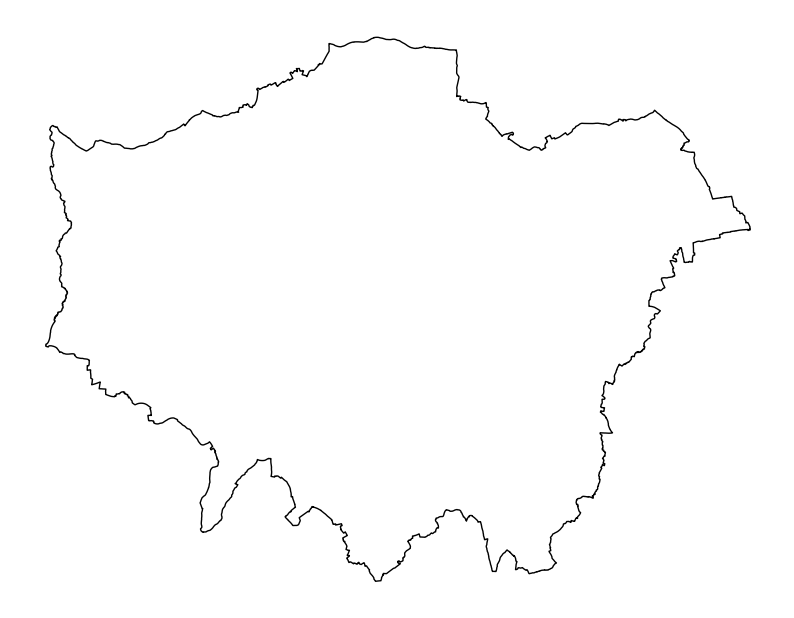

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
greater_london.plot(ax=ax, color='white', edgecolor='black')
plt.axis('off') 
plt.show()

In [59]:
# subset points that are within the boundary of london
bus_entex_pivot = bus_entex_pivot[bus_entex_pivot.geometry.intersects(greater_london.geometry[0])]
bus_entex_pivot.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 48846 entries, 0 to 50212
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STOPCODE  48846 non-null  object  
 1   STOPNAME  48846 non-null  object  
 2   ROUTE     48846 non-null  object  
 3   geometry  48846 non-null  geometry
 4   Morning   46952 non-null  float64 
 5   Midday    40712 non-null  float64 
 6   Late      45510 non-null  float64 
 7   Evening   39374 non-null  float64 
 8   Total     48846 non-null  float64 
dtypes: float64(5), geometry(1), object(3)
memory usage: 3.7+ MB


EXPORT

In [61]:
# export to geojson AGGREGATED BY STOP AND ROUTE
bus_entex_pivot.to_file('data/cleaned/flow_bus_byStopRoutes_.gpkg', driver='GPKG')

### AGGREGATE BY STOPS ONLY

In [62]:
# sum flow_bus by stop_id, aggregate all numerical columns
flow_bus_byStop = bus_entex_pivot.groupby(['STOPCODE','STOPNAME']).agg({
    'geometry': 'first',
    'Morning': 'sum',
    'Midday': 'sum',
    'Evening': 'sum',
    'Late': 'sum',
    'Total': 'sum'
}).reset_index()
flow_bus_byStop = gpd.GeoDataFrame(flow_bus_byStop, geometry='geometry', crs='EPSG:27700')
flow_bus_byStop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18581 entries, 0 to 18580
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STOPCODE  18581 non-null  object  
 1   STOPNAME  18581 non-null  object  
 2   geometry  18581 non-null  geometry
 3   Morning   18581 non-null  float64 
 4   Midday    18581 non-null  float64 
 5   Evening   18581 non-null  float64 
 6   Late      18581 non-null  float64 
 7   Total     18581 non-null  float64 
dtypes: float64(5), geometry(1), object(2)
memory usage: 1.1+ MB


In [63]:
# export to geojson AGGREGATED BY STOP
flow_bus_byStop.to_file('data/cleaned/flow_bus_byStop_.gpkg', driver='GPKG')